<a href="https://colab.research.google.com/github/serg-kas/NN-archive/blob/main/%D0%90%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_2020_Light_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_33_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D0%BB%D0%BE%D1%81%D0%BE%D0%B2%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light задание

1.  Используя микрофон, запишите несколько аналогичных команд своим голосом и проверьте результат работы предсказания сетки. Сделайте вывод о дикторозависимости в такой модели
2.  Используя микрофон, запишите и добавьте в текущую базу по 5-10 команд своим голосом и проверьте результаты работы сетки на обновленной базе

## Импорт библиотек, подключение диска, глобальные параметры


In [ ]:
import numpy as np                                   # библиотека для работы с массивами данных
from matplotlib import pyplot as plt                 # интерфейс для построения графиков простых функций
from IPython.display import Audio                    # загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from google.colab import files                       # модуль для загрузки файлов
import librosa                                       # для параметризации аудио
import os                                            # модуль для работы с операционной системой(воспользуемся методами работы с каталогами)
from sklearn.model_selection import train_test_split # модуль для разбивки данных на обучающую и тестовую выборки
from tensorflow.keras.utils import to_categorical    # загружаем утилиты кераса для one hot кодировки
from tqdm.notebook import tqdm_notebook as tqdm_
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta # загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.models import Sequential       # последовательная модель нейросети кераса
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape # загружаем необходимые слои для нейросети
import IPython.display as ipd                        # Воспроизведение звуковыйх файлов
from matplotlib.patches import Rectangle

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/My Drive/my_sample_data/Д.З.33/comands/"          # зададим путь к папке с аудиофайлами
DATA_PATH_TEST = "/content/drive/My Drive/my_sample_data/Д.З.33/test_speech/" # зададим пусть к файлу с тестовыми 30секнудными аудиофайлами

sample_rate = 22050                              # значение sample_rate аудиофайлов
feature_dim_1 = 20                               # стандартная величина MFCC признаков 
feature_dim_2 = int(.5 * sample_rate)            # установленная длина фреймов (в секундах 0.5 = 500 мс)
step_mfcc = int(.02 * sample_rate)               # шаг смещения при разборе mfcc (в секундах 0.1 = 100мс)
channel = 1                                      # количество каналов
n_classes = 4                                    # количество классов команд
classes = ['КОНДИЦИОНЕР', 'СВЕТ', 'ТЕЛЕВИЗОР']   # классы команд (без фона)


## Объявление функций


In [ ]:
'''
Зададим функцию извлечения лейблов классов и их обработки
  Параметры:
    path - путь к папке, в которой находятся каталоги с обучающими командами    
'''

def get_labels(path=DATA_PATH): 
  labels = sorted(os.listdir(path))                           # запишем лейблы классов по названию папок с данными - ['кондиционер', 'телевизор', 'свет', 'фон']  
  label_indices = np.arange(0, len(labels))                   # запишем лейблы в виде индексов - [0, 1, 2, 3]
  return labels, label_indices, to_categorical(label_indices) # функция вернёт лейблы, индексы лейблов и их one-hot представление[0, 1, 0, 0]

In [ ]:
'''
Создаем функцию параметризации аудио(wav в мел-частоты)
  Параметры:
    length - длинна отрезков, на которые разбиваем исходный файл
    step - шаг, на который смещаем разбиение отрезка
'''

def wav2mfcc(file_path, length = 11025, step = 2205): 
  out_mfcc = []                    # Выходной массив, содержащий mfcc исходного файла с шагом step
  out_audio = []                   # Выходной массив, содержащий аудиоинформацию исходного файла с шагом step
  y, sr = librosa.load(file_path)  # Загружаем данные исходного файла  

  while (len(y)>=length):          # Проходим весь массив y, пока оставшийся кусочек не станет меньше указанной в параметре max_len длинны
    section = y[:length]           # Берем начальный кусок длинной length
    section = np.array(section)    # Переводим в numpy
    out_mfcc.append(librosa.feature.mfcc(section, sr, n_mfcc=feature_dim_1)) # Добавляем в выходной массив out_mfcc значение mfcc текущего куска
    out_audio.append(section)      # Добавляем в выходной массив аудио текущий кусок
    y = y[step:]                   # Уменьшаем y на step
    
  out_mfcc = np.array(out_mfcc)    # Преобразуем в numpy
  out_audio = np.array (out_audio) # Преобразуем в numpy
  return out_mfcc, out_audio       # функция вернет массив мэл-частот и массив аудио-отрезков

In [ ]:
'''
Объявим функцию формирования и сохранения векторов данных, полученных для каждого набора аудио-команд в датасете
  Параметры:
    path  - путь к папке, в которой находятся каталоги с обучающими командами    
    length - длинна отрезков, на которые разбиваем исходный файл
'''

def save_data_to_array(path=DATA_PATH, length=11025):
  labels, _, _ = get_labels(path)                        # запишем лейблы классов
  for label in labels:                                   # для каждого лейбла
    mfcc_vectors = []                                    # здесь соберем векторы MFCC частот
    # извлечем для каждого файла его путь c названием папки и именем файла и соберём в список
    # ['/content/drive/My Drive/Речевые команды/свет/recording12.wav', '/content/drive/My Drive/Речевые команды/свет/recording11.wav'..]
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    for wavfile in tqdm_(wavfiles, desc=('Сохраняем векторы класса ' + label), ncols=1000):    
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc) # получим мел-частоты      
      if (mfcc.shape[0] != 0 ):                          # Если массив не нулевой длинны
        mfcc_vectors.extend(mfcc)                        # и добавим вектор в список для соответствующего класса
    np.save('/content/drive/My Drive/my_sample_data/Д.З.33/numpy/'+label + '.npy', mfcc_vectors)                # сохраним массивы данных для каждого класса

In [ ]:
'''
Создадим функцию для получения обучающей/проверочной выборки
  Параметры (необязательные):
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split
    random_state - начальное число, используемое генератором случайных чисел в финкции train_test_split
'''

def get_train_test(split_ratio=0.7, random_state=42, colab = True):
  labels, indices, _ = get_labels(DATA_PATH) # извлекаем имена и индексы лейблов классов

  # Getting first arrays
  X = np.load('/content/drive/My Drive/my_sample_data/Д.З.33/numpy/'+labels[0] + '.npy') # берем набор векторов для первого класса 
  y = np.zeros(X.shape[0], dtype = 'int32')                     # устанавливаем размер соответствующего ему лейбла

  # Объединяем в единый датасет в виде np-массива обучающий и проверочный набор данных
  for i, label in enumerate(labels[1:]): 
    if colab:
      x = np.load(label + '.npy') # Читаем очередной массив данных 
    else:
      x = np.load('/content/drive/My Drive/my_sample_data/Д.З.33/numpy/'+label + '.npy') # Читаем очередной массив данных 
    X = np.vstack((X, x)) # Соединяем с исходным набором
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))  # в массив y добавлем x.shape[0]-элеменентов со значением (i + 1)

  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) # Разделяем данные на обучающую и проверочную выборки

## Подготовка данных

In [ ]:
# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете
save_data_to_array(path=DATA_PATH, length=feature_dim_2)

In [ ]:
##########################
# Формируем обучающую и проверочную выборки
##########################
x_train, x_test, y_train, y_test = get_train_test(colab=False) # создаем обучающий/проверочный наборы
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(65700, 20, 22) (65700,)
(28158, 20, 22) (28158,)


In [ ]:
# Добавляем значение канала(=1) в размеры 'x' выборок
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], channel)
x_train = x_train[..., None]
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], channel)
x_test = x_test[..., None]

y_train_hot = to_categorical(y_train) # представляем лейблы классов обучающего набора в виде one-hot вектора ((0, 1, 0) и т.п)
y_test_hot = to_categorical(y_test) # представляем лейблы классов проверочного набора в виде one-hot вектора ((0, 1, 0) и т.п)

**Посмотрим размеры выборки в целом и по отдельным классам**

In [ ]:
x_train.shape

(65700, 20, 22, 1)

In [ ]:
idx = np.where(y_train==0)
idx[0].shape

(5729,)

In [ ]:
idx = np.where(y_train==1)
idx[0].shape

(3036,)

In [ ]:
idx = np.where(y_train==2)
idx[0].shape

(6215,)

In [ ]:
idx = np.where(y_train==3)
idx[0].shape

(50720,)

## Нейросеть

In [ ]:
##########################
# Объявим функцию создания модели нейросети
##########################
def get_model():
  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(BatchNormalization())           # пропускаем через слой нормализации данных
  model.add(Flatten())                      # сплющиваем в одномерный вектор  
  model.add(Dense(128, activation='relu'))  # добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25))                  # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization())           # пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # добавляем полносвязный слой с функцией активации softmax на выходном слое для 3 классов
  model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])       # компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  return model

In [ ]:
model = get_model() # создаем модель с помощью объявленной ранее функции
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 18, 20, 8)         80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 10, 8)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 9, 10, 8)          32        
_________________________________________________________________
flatten_9 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               92288     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)             

Epoch 1/30
257/257 [==============================] - 2s 4ms/step - loss: 0.4966 - accuracy: 0.8218 - val_loss: 0.0651 - val_accuracy: 0.9832
Epoch 2/30
257/257 [==============================] - 1s 4ms/step - loss: 0.0491 - accuracy: 0.9852 - val_loss: 0.0321 - val_accuracy: 0.9908
Epoch 3/30
257/257 [==============================] - 1s 4ms/step - loss: 0.0314 - accuracy: 0.9901 - val_loss: 0.0240 - val_accuracy: 0.9912
Epoch 4/30
257/257 [==============================] - 1s 4ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.0164 - val_accuracy: 0.9947
Epoch 5/30
257/257 [==============================] - 1s 4ms/step - loss: 0.0205 - accuracy: 0.9930 - val_loss: 0.0142 - val_accuracy: 0.9940
Epoch 6/30
257/257 [==============================] - 1s 4ms/step - loss: 0.0164 - accuracy: 0.9942 - val_loss: 0.0109 - val_accuracy: 0.9961
Epoch 7/30
257/257 [==============================] - 1s 4ms/step - loss: 0.0156 - accuracy: 0.9944 - val_loss: 0.0094 - val_accuracy: 0.9970
Epoch 

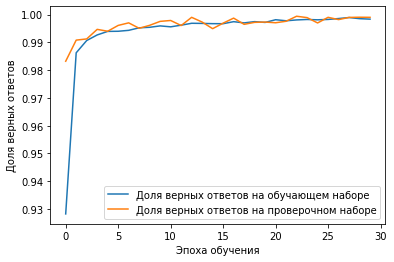

In [ ]:
##########################
# Запустим тренировку нейросети на полученных данных
##########################

# Загружаем модель данными с выбором параметров и сохраним историю обучения(ошибки/точность) для вывода графика
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=30, verbose=1, validation_data=(x_test, y_test_hot))

# Построим график, отображающий точность предсказания на обучающей и проверочной выборке
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#model.save_weights('/content/drive/MyDrive/my_sample_data/Д.З.33/speech_new.h5')
#model.load_weights('/content/drive/MyDrive/my_sample_data/Д.З.33/speech_new.h5')

## Проверка распознавания (функция)

In [ ]:
##########################
# Объявим функцию предсказания команды
##########################
def predict(namefile, model, min_count = 2, rate = 0.9, hole = 1):  # функция принимает на вход путь к нужному файлу, и имя обученной модели 
    mfcc_full, audio_full = wav2mfcc(namefile, length=feature_dim_2, step = step_mfcc)  # Получаем массив mfcc выбранного файла с именем namefile    

    #mfcc = xScaler.transform(mfcc_full.reshape(-1,1))
    mfcc_full = mfcc_full.reshape(-1, feature_dim_1, 22, 1)     #feature_dim_1 = 20
    g_pred = model.predict(mfcc_full)               # Предиктим с помощью модели model массив mfcc
    pred = np.array([np.argmax(i) for i in g_pred]) # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов

    out = []    # Объявляем выходную переменную out (В ней будут храниться преобразованные из mfcc ауидоданные, класс команды и точность, с которой сеть считает эту команду верной)  
  
    # Ищем команды каждого класса
    for idx_class in range(n_classes-1):
      idxs = np.where(pred == idx_class)  # В массиве pred находим все элементы со значением, равным искомому классу idx_class
      idxs = idxs[0]                      # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность
      if (len(idxs) == 0):                # Если элементы искомого класса не найдены,
        continue                          # то переходим к поиску команд следующего класса

      curr = [] # Временный массив для хранения информации о найденных командах
      '''
      в массиве idx данные прдеставлены следующим образом:
      [4, 5, 6, 7, 123, 124, 125, 126, 127]
      в массив curr мы запишем [4, 123] только стартовые индексы
      поскольку очевидно, что 4,5,6,7 и 123,124,125,126,127 представляют единую команду
      '''
      curr_idx =int(idxs[0])  # Текущий стартовый индекс
      summ, length = 0, 0     # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера                                                                        
                              #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
      
      for i in range(len(idxs)):              # Пробегаем по всему массиву idxs
        summ += g_pred[idxs[i]][idx_class]    # Считаем сумму вероятности
        length += 1                           # Увеличиваем длинну последовательности
        if i == len(idxs)-1:                  # Если последний элемент последовательности
          if (length >= min_count and summ / length >= rate):   # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                                # summ / length должно быть больше входного параметра rate
            curr.append([curr_idx, length, summ / length])      # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length

          break  
        if idxs[i+1]-idxs[i]>hole:                            # Если следующий индекс больше текущего на hole (означает, что следующий элемент относится уже к другой комманде)
          if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                              # summ / length должно быть больше входного параметра rate
 #           print(length)
            curr.append([curr_idx, length, summ / length])  # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
          curr_idx = int (idxs[i+1])                        # Изменяем текущий стартовый индекс
          summ, length = 0, 0                               # Обнуляем summ и length
      curr_audio = [] 
      for elem in curr:                                     # Проходим по всему массиву curr
        curr_audio = audio_full[elem[0]]      # Если это стартовый элемент исходных данных, то берем самую первую mfcc
        for j in range(1,elem[1]):            # Пробегаем цикл от 1 до elem[1]+1 (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
         if (elem[0]+j == len(audio_full)):   # Если elem[0] + j равно длинне mfcc, то выходим из цикла
           break
         curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
        curr_audio = np.array(curr_audio)             # Переводим массив в numpy
        out.append([curr_audio, idx_class, elem])  # Добавляем данные в выходной массив
    return out, pred                         # Возращаем массив с данными, массив с классами команд, массив с softmax данными

**Здесь проверим распознавание команды записанной моим голосом нейронкой обученной  на базе с вебинара**

In [ ]:
model.load_weights('/content/drive/MyDrive/my_sample_data/Д.З.33/speech.h5')

In [ ]:
DATA_PATH_TEST_NEW = '/content/drive/My Drive/my_sample_data/Д.З.33/test_speech_new/'


Распознана команда: " СВЕТ " (вероятность - 90.62 %)


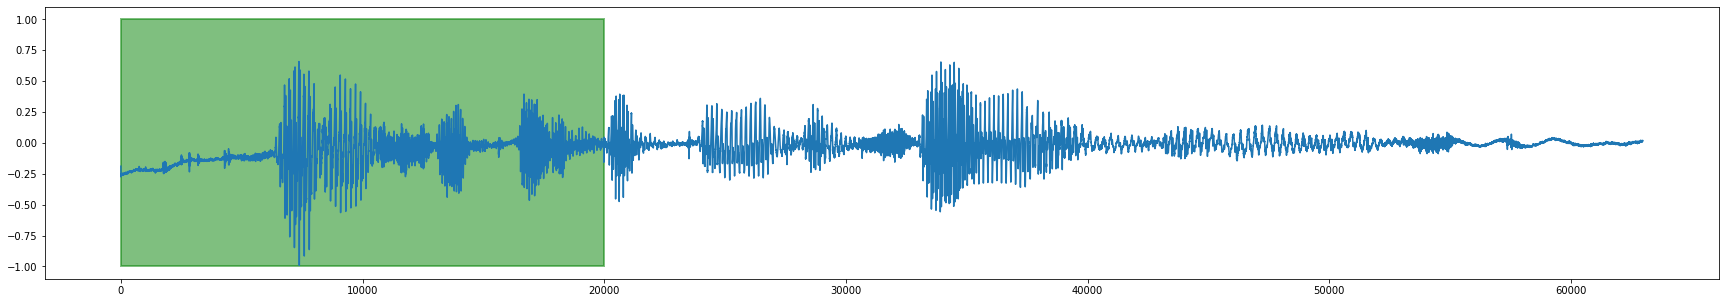

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст кондиционер 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 



Распознана команда: " СВЕТ " (вероятность - 93.65 %)


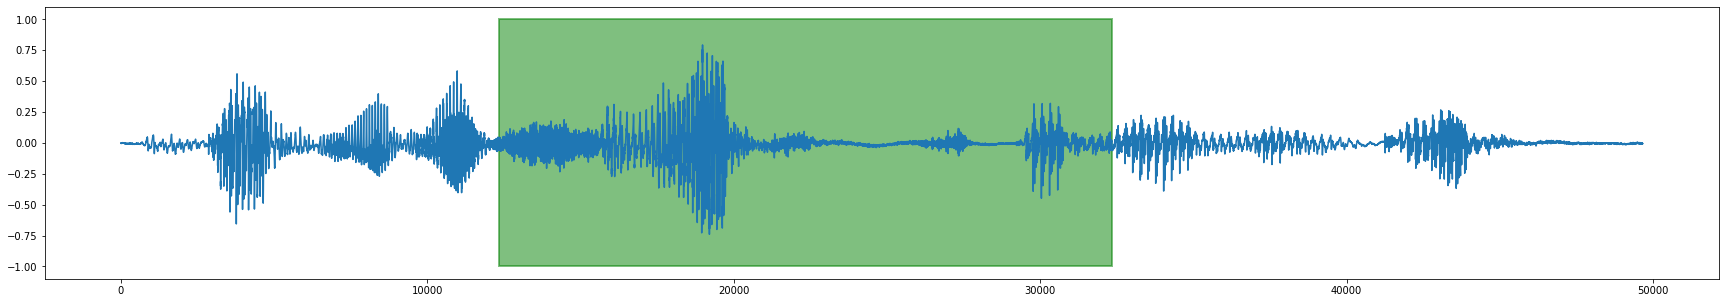

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст свет 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " СВЕТ " (вероятность - 84.62 %)


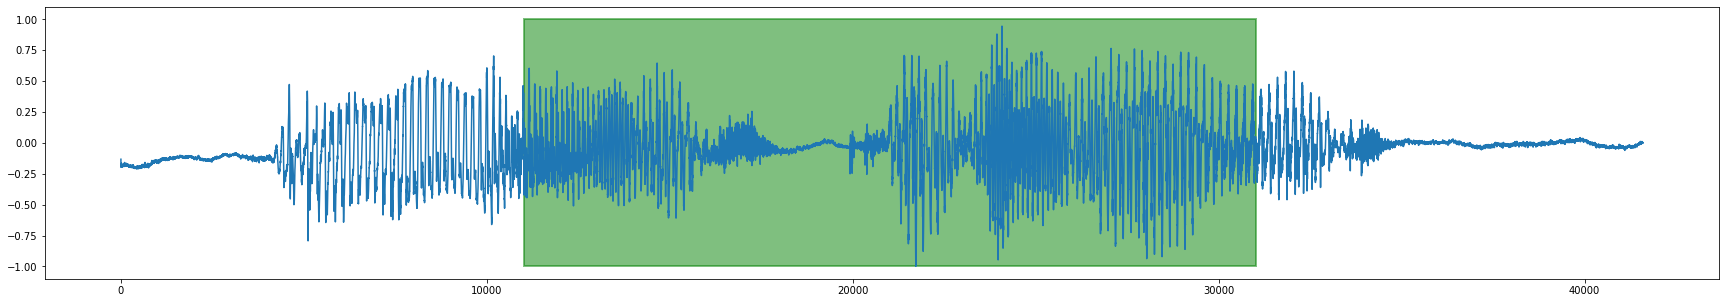

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст телевизор 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 

**Результат в целом плохой (хуже чем на вебинаре, распознали 1 команду из 3). Так что дикторозависимость налицо.**

**Далее вставим в обучающие выборки по 5 команд записанных моим голосом и переучим  нейронку на обновленной базе**

(все параметры оставляем теже, только добавили новые команды в базу)




In [ ]:
model.load_weights('/content/drive/MyDrive/my_sample_data/Д.З.33/speech_new.h5')


Распознана команда: " КОНДИЦИОНЕР " (вероятность - 89.13 %)


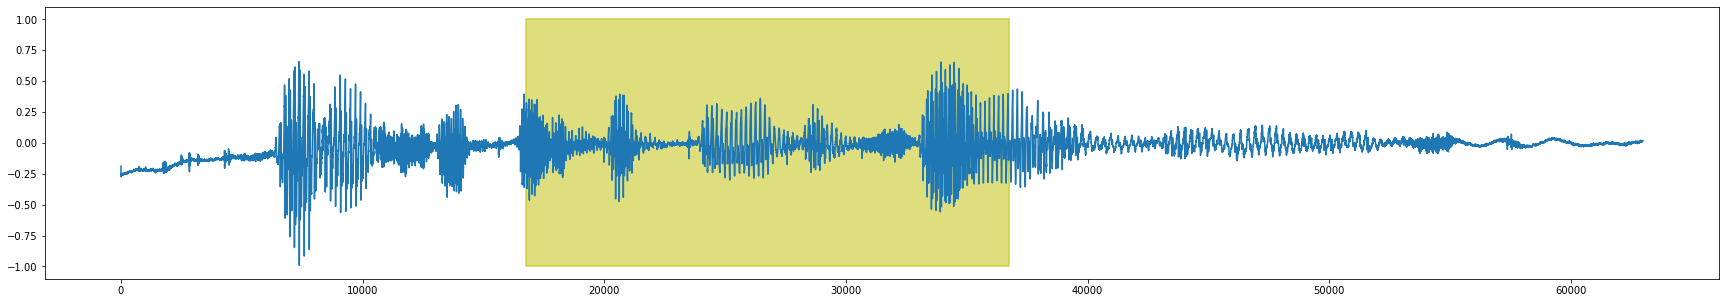

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст кондиционер 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " СВЕТ " (вероятность - 93.90 %)


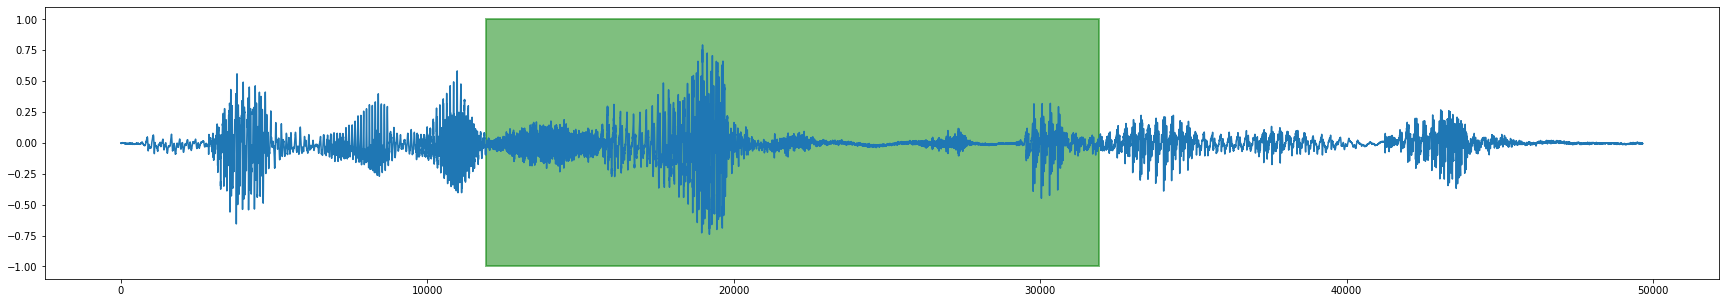

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст свет 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " КОНДИЦИОНЕР " (вероятность - 98.90 %)


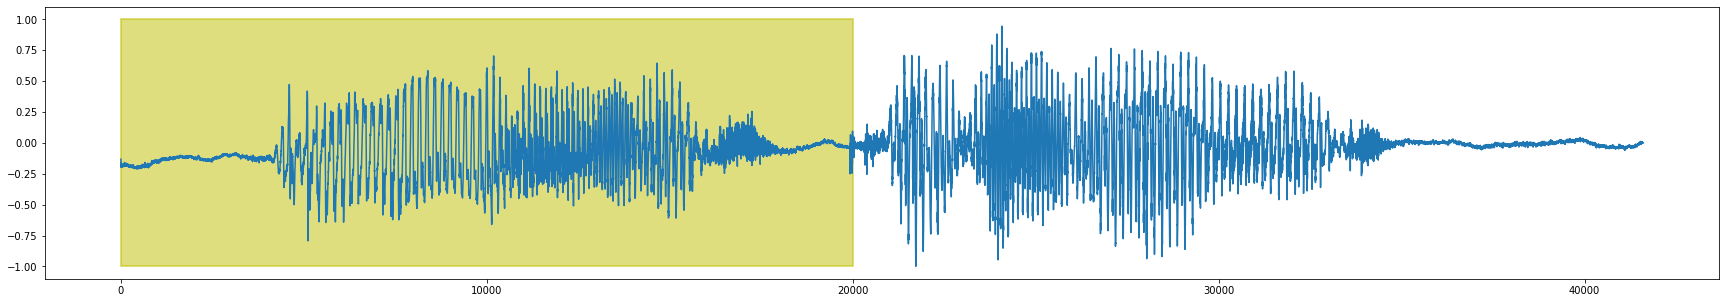

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст телевизор 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 

**Тенденция к улучшению есть (распознали 2 из 3 команды). Хотя до идеала далеко** 

**Главное увидеть получилось: при наличии в базе "знакомого" голоса результат последующего разпознавания улучшается**

# PRO задание
Меняя параметры/гиперпараметры модели и подход к формированию выборки, добейтесь максимальной точности сетки.

**Теперь попробуем еще улучшить результат путем расширения выборки с командами. По сути я удвою количество записей команд создав их копии**

**Команды своим голосом добавляю еще по 5 на класс (всего по 10)**

**Идея в том, чтобы попытаться преодолеть явный дисбаланс в датасете по отношению к данным класса "шум"**

Использованы функции подготовки данных из раздела Light.

In [ ]:
##########################
# Объявим функцию создания модели нейросети
##########################
def get_model():
  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  #model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) # передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(BatchNormalization()) # пропускаем через слой нормализации данных
  model.add(Flatten()) # сплющиваем в одномерный вектор  
  model.add(Dense(128, activation='relu')) # добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25))
  #model.add(Dense(16, activation='relu'))
  #model.add(Dropout(0.25)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization()) # пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # добавляем полносвязный слой с функцией активации softmax на выходном слое для 3 классов
  model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy']) # компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  return model

In [ ]:
model2 = get_model() # создаем модель с помощью объявленной ранее функции
model2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 18, 20, 8)         80        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 9, 10, 8)          0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 9, 10, 8)          32        
_________________________________________________________________
flatten_15 (Flatten)         (None, 720)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               92288     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 128)             

Epoch 1/10
129/129 [==============================] - 1s 7ms/step - loss: 0.7054 - accuracy: 0.7428 - val_loss: 0.1114 - val_accuracy: 0.9613
Epoch 2/10
129/129 [==============================] - 1s 4ms/step - loss: 0.0754 - accuracy: 0.9785 - val_loss: 0.0510 - val_accuracy: 0.9886
Epoch 3/10
129/129 [==============================] - 1s 4ms/step - loss: 0.0411 - accuracy: 0.9886 - val_loss: 0.0280 - val_accuracy: 0.9941
Epoch 4/10
129/129 [==============================] - 1s 4ms/step - loss: 0.0250 - accuracy: 0.9932 - val_loss: 0.0201 - val_accuracy: 0.9955
Epoch 5/10
129/129 [==============================] - 1s 4ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.0131 - val_accuracy: 0.9967
Epoch 6/10
129/129 [==============================] - 1s 4ms/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.0126 - val_accuracy: 0.9960
Epoch 7/10
129/129 [==============================] - 1s 4ms/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 0.0123 - val_accuracy: 0.9961
Epoch 

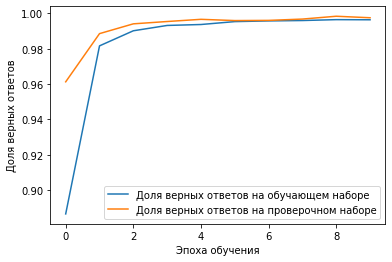

In [ ]:
##########################
# Запустим тренировку нейросети на полученных данных
##########################

# Загружаем модель данными с выбором параметров и сохраним историю обучения(ошибки/точность) для вывода графика
history = model2.fit(x_train, y_train_hot, batch_size=512, epochs=10, verbose=1, validation_data=(x_test, y_test_hot))

# Построим график, отображающий точность предсказания на обучающей и проверочной выборке
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model2.save_weights('/content/drive/MyDrive/my_sample_data/Д.З.33/speech_new2x.h5')
#model2.load_weights('/content/drive/MyDrive/my_sample_data/Д.З.33/speech_new2x.h5')

**Проверим распознавание на новозаписанных тестостовых файлах**

In [ ]:
DATA_PATH_TEST_NEW = '/content/drive/My Drive/my_sample_data/Д.З.33/test_speech_new/'


Распознана команда: " КОНДИЦИОНЕР " (вероятность - 80.24 %)


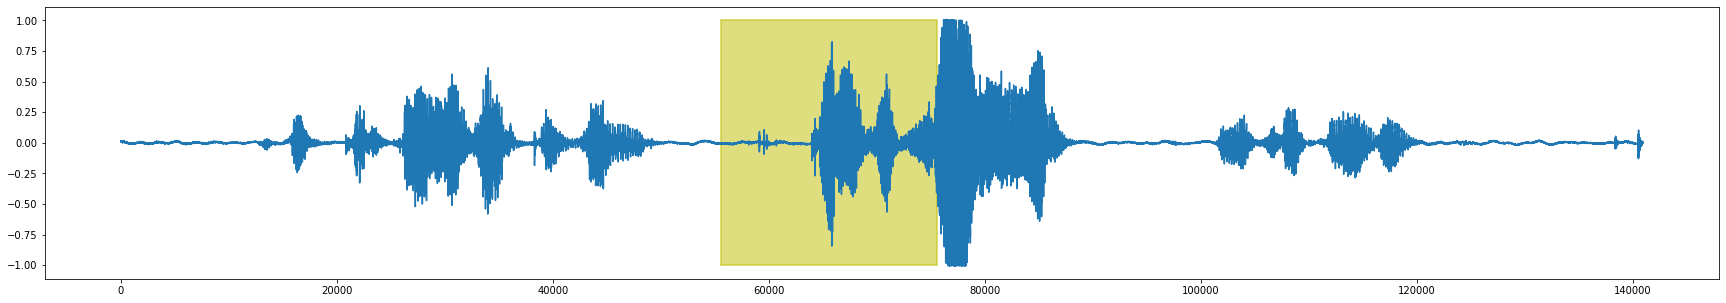

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст кондиционер 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model2, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " СВЕТ " (вероятность - 83.64 %)


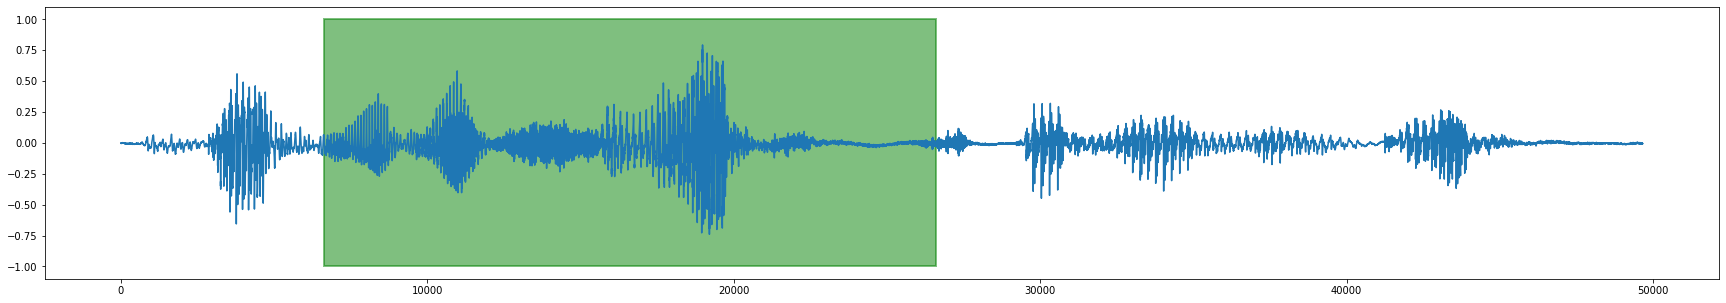

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст свет 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model2, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " КОНДИЦИОНЕР " (вероятность - 93.53 %)


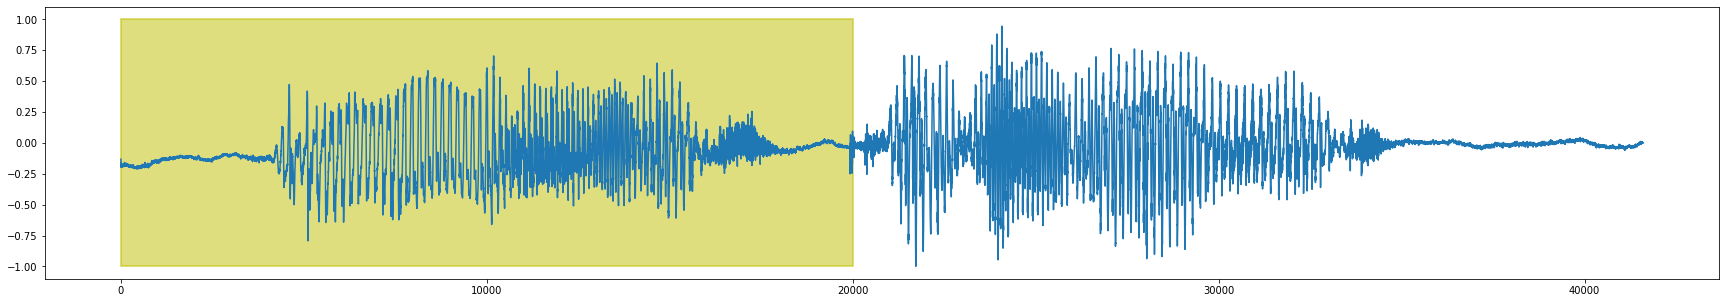

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст телевизор 1.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model2, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " КОНДИЦИОНЕР " (вероятность - 81.82 %)


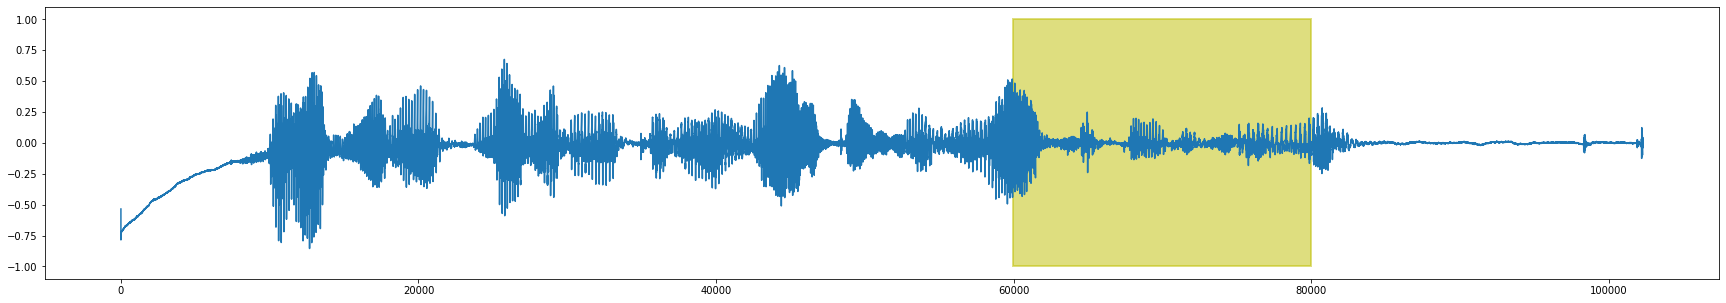

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст кондиционер 2.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model2, min_count = 6, rate = 0.8, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " СВЕТ " (вероятность - 94.16 %)


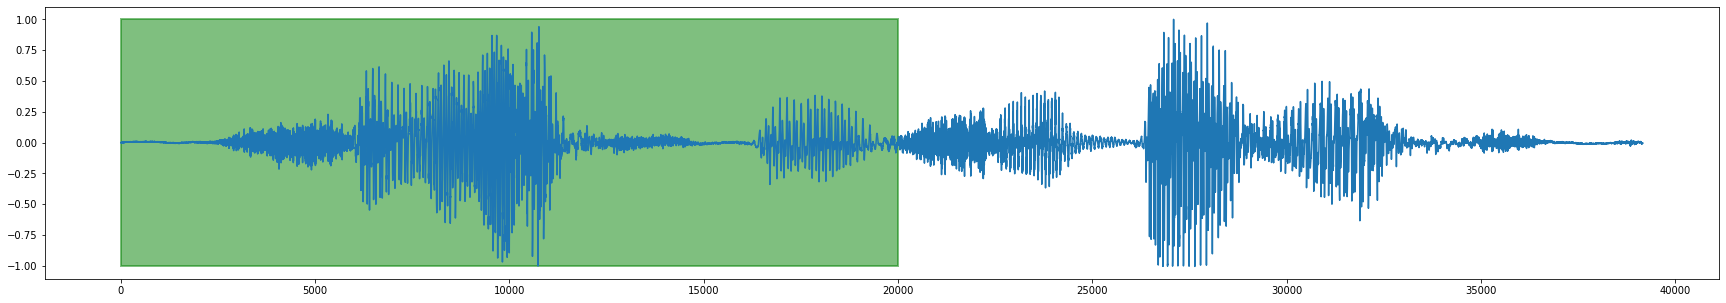

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст свет 2.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model2, min_count = 6, rate = 0.80, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 


Распознана команда: " ТЕЛЕВИЗОР " (вероятность - 98.08 %)


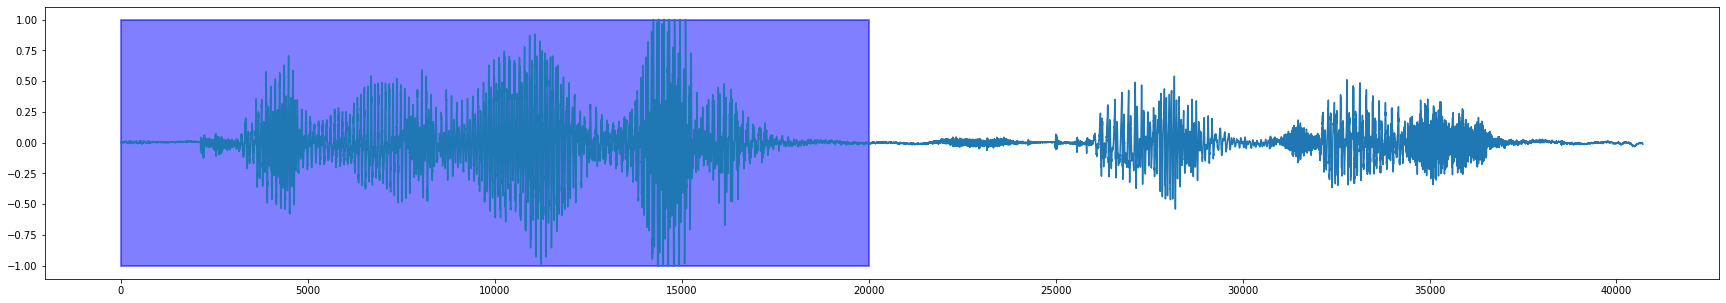

In [ ]:
wavfiles =  DATA_PATH_TEST_NEW + 'Текст телевизор 2.wav' # Получаем имя очередного файла
y_org,sr = librosa.load(wavfiles)      
ipd.display(ipd.Audio (y_org, rate = sr))
print()
#out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
out, pred = predict(wavfiles, model=model2, min_count = 6, rate = 0.9, hole = 2)      # Вызываем predict для очередного файла  
color = ['y','g','b']
if (len(out)==0):                                                    # Если длинна массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
else:
  for elem in out[:1]: 
    print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2][2]*100), '%)')   # Выводим название
    ipd.display(ipd.Audio(elem[0], rate = 22050))
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111) 
    plt.plot(y_org)
    ax.add_patch(Rectangle((441*elem[2][0], 1.), 
                            20000, -2, 
                              fc =color[elem[1]],  
                              ec =color[elem[1]], 
                              fill=True,
                              lw = 2,
                              alpha=0.5) ) 

**В итоге из 6 новозаписанных тестовых файла с моим голосом разпознали 5**

**Архитектуру пробовал разную, но в итоге вернулся к самой простой сети с первым сверточным и промежуточным полносвязным слоямию**

**Пробовал брать 40 отсчетов mfcc - вернулся на 20**


